# Présentation des premières Dataviz
__________________________________________________________________

> Par C. FONTAINE, F. LAVERRIERE et P. NGUYEN

## 0- Objectif de ce notebook

Dans le cadre du projet WildFires, nous avons essayé de répondre à différentes problématiques en explorant le jeu de données et en synthétisant les premiers éléments de réponse dans différentes Dataviz. Ce notebook regroupe les premières pertinentes.

## 1- Chargement des librairies et du jeu de données initial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
df = pd.read_csv('Fires_filter.csv', index_col = 'OBJECTID')
df.DISCOVERY_DATE = pd.to_datetime(df.DISCOVERY_DATE)
df.CONT_DATE = pd.to_datetime(df.CONT_DATE)

## 2- Evaluation du nombre et de l'importance des feux par état

Evaluons dans un premier temps la répartition du nombre de feux par état.

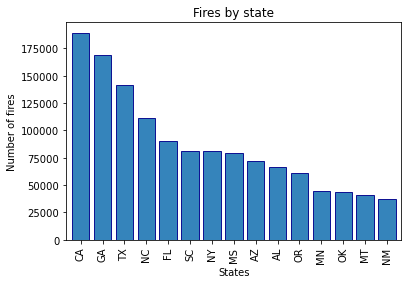

In [3]:
df['STATE'].value_counts().sort_values(ascending = False)[:15].plot(kind = 'bar', width = 0.8, alpha = 0.9,  edgecolor = 'darkblue', 
                                                            ylabel = "Number of fires", xlabel = 'States', title = 'Fires by state');

Evaluons maintenant la répartition des surfaces totales brûlées par état.

In [4]:
df_size = df.groupby('STATE')['FIRE_SIZE'].agg(['sum'])

df_size.head()

,sum
STATE,
AK,3.223309e+07
AL,9.205453e+05
AR,5.089118e+05
AZ,5.576681e+06
CA,1.274586e+07


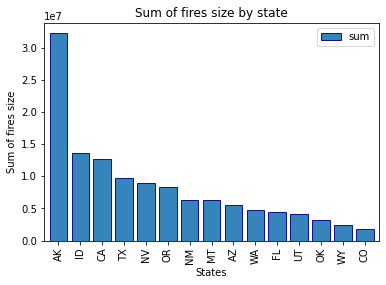

In [5]:
df_size.sort_values(by = 'sum', ascending=False)[:15].plot(kind="bar", width = 0.8, alpha = 0.9,  edgecolor = 'darkblue', 
                                                            ylabel = "Sum of fires size", xlabel = 'States', title = 'Sum of fires size by state');

> **Conclusion n°1 :** Instinctivement, nous avons cherché à savoir quel état est le plus impacté par les feux de forêt. En quantité nous voyons donc c’est c’est la Californie qui subit le plus de feux, alors que l’Alaska n’est même pas dans le top 15. Cependant, lorsqu’on regarde au niveau des tailles des feux, c’est l’Alaska qui subit les plus grands feux, largement au delà de la Californie qui n’est que 3e dans ce classement.

Regardons maintenant l'évolution du nombre de feux par type de feux, par état, au cours de la période d'observation

## 3- Evaluation du nombre de feux, par type de feux, par état

#### Préparation des données

In [24]:
df = df.join(pd.get_dummies(df.FIRE_SIZE_CLASS), on = 'OBJECTID')

In [25]:
df_adv_count = df.groupby(['FIRE_YEAR', 'STATE'], as_index = False)[['A', 'B', 'C', 'D', 'E', 'F', 'G']].sum()

In [26]:
df_adv_count

,FIRE_YEAR,STATE,A,B,C,D,E,F,G
0,1992,AK,260.0,149.0,40.0,13.0,7.0,9.0,3.0
1,1992,AL,17.0,51.0,22.0,3.0,0.0,0.0,0.0
2,1992,AR,25.0,69.0,32.0,1.0,1.0,0.0,0.0
3,1992,AZ,1839.0,1308.0,274.0,44.0,19.0,10.0,0.0
4,1992,CA,5997.0,3982.0,602.0,135.0,72.0,36.0,9.0
...,...,...,...,...,...,...,...,...,...
1209,2015,VT,31.0,52.0,3.0,1.0,0.0,0.0,0.0
1210,2015,WA,985.0,556.0,88.0,38.0,33.0,18.0,23.0
1211,2015,WI,534.0,388.0,38.0,3.0,2.0,0.0,0.0
1212,2015,WV,222.0,322.0,105.0,22.0,11.0,3.0,0.0


In [27]:
for i in df.FIRE_SIZE_CLASS.unique().tolist():
    col_name = 'cumsum_' + str(i)
    df_adv_count[col_name] = df_adv_count[i]
    for j in df_adv_count.STATE.unique().tolist():
        list_index = df_adv_count[df_adv_count.STATE == j].index
        base = df_adv_count.iloc[list_index[0], df_adv_count.columns.get_loc(i)]
        for k in list_index[1:]:
            df_adv_count.iloc[k, df_adv_count.columns.get_loc(col_name)] = base + df_adv_count.iloc[k, df_adv_count.columns.get_loc(col_name)]
            base = df_adv_count.iloc[k, df_adv_count.columns.get_loc(col_name)]

In [28]:
df_adv_count

,FIRE_YEAR,STATE,A,B,C,D,E,F,G,cumsum_A,cumsum_B,cumsum_G,cumsum_C,cumsum_D,cumsum_F,cumsum_E
0,1992,AK,260.0,149.0,40.0,13.0,7.0,9.0,3.0,260.0,149.0,3.0,40.0,13.0,9.0,7.0
1,1992,AL,17.0,51.0,22.0,3.0,0.0,0.0,0.0,17.0,51.0,0.0,22.0,3.0,0.0,0.0
2,1992,AR,25.0,69.0,32.0,1.0,1.0,0.0,0.0,25.0,69.0,0.0,32.0,1.0,0.0,1.0
3,1992,AZ,1839.0,1308.0,274.0,44.0,19.0,10.0,0.0,1839.0,1308.0,0.0,274.0,44.0,10.0,19.0
4,1992,CA,5997.0,3982.0,602.0,135.0,72.0,36.0,9.0,5997.0,3982.0,9.0,602.0,135.0,36.0,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,2015,VT,31.0,52.0,3.0,1.0,0.0,0.0,0.0,166.0,267.0,0.0,20.0,3.0,0.0,0.0
1210,2015,WA,985.0,556.0,88.0,38.0,33.0,18.0,23.0,19823.0,10895.0,152.0,1713.0,411.0,241.0,278.0
1211,2015,WI,534.0,388.0,38.0,3.0,2.0,0.0,0.0,18271.0,12391.0,1.0,1110.0,57.0,7.0,24.0
1212,2015,WV,222.0,322.0,105.0,22.0,11.0,3.0,0.0,6443.0,10625.0,1.0,3712.0,797.0,79.0,310.0


#### Affichage de l'évolution du nombre de feux

Mise en place d'un dictionnaire associant à chaque type de feu, les 10 états ayant cumulé le plus de feux sur la période.

In [29]:
list_col = df_adv_count.iloc[:, 9:].columns.tolist()
list_col.sort()
list_col

['cumsum_A',
 'cumsum_B',
 'cumsum_C',
 'cumsum_D',
 'cumsum_E',
 'cumsum_F',
 'cumsum_G']

In [30]:
dict_col = {}
for i in list_col:
    dict_col[i] = df_adv_count.query('FIRE_YEAR == 2015').nlargest(10, i).STATE.tolist()
dict_col

{'cumsum_A': ['CA', 'GA', 'NY', 'OR', 'AZ', 'NC', 'CO', 'MT', 'ID', 'FL'],
 'cumsum_B': ['GA', 'TX', 'CA', 'NC', 'SC', 'FL', 'MS', 'AL', 'NY', 'MN'],
 'cumsum_C': ['TX', 'MS', 'AL', 'FL', 'GA', 'OK', 'SC', 'CA', 'KY', 'AR'],
 'cumsum_D': ['TX', 'CA', 'FL', 'OK', 'KY', 'MS', 'ID', 'AL', 'NM', 'AZ'],
 'cumsum_E': ['TX', 'CA', 'OK', 'FL', 'ID', 'NM', 'AZ', 'MT', 'KY', 'SD'],
 'cumsum_F': ['TX', 'CA', 'ID', 'NM', 'OK', 'AK', 'AZ', 'NV', 'FL', 'MT'],
 'cumsum_G': ['AK', 'CA', 'ID', 'NV', 'OR', 'TX', 'NM', 'MT', 'AZ', 'WA']}

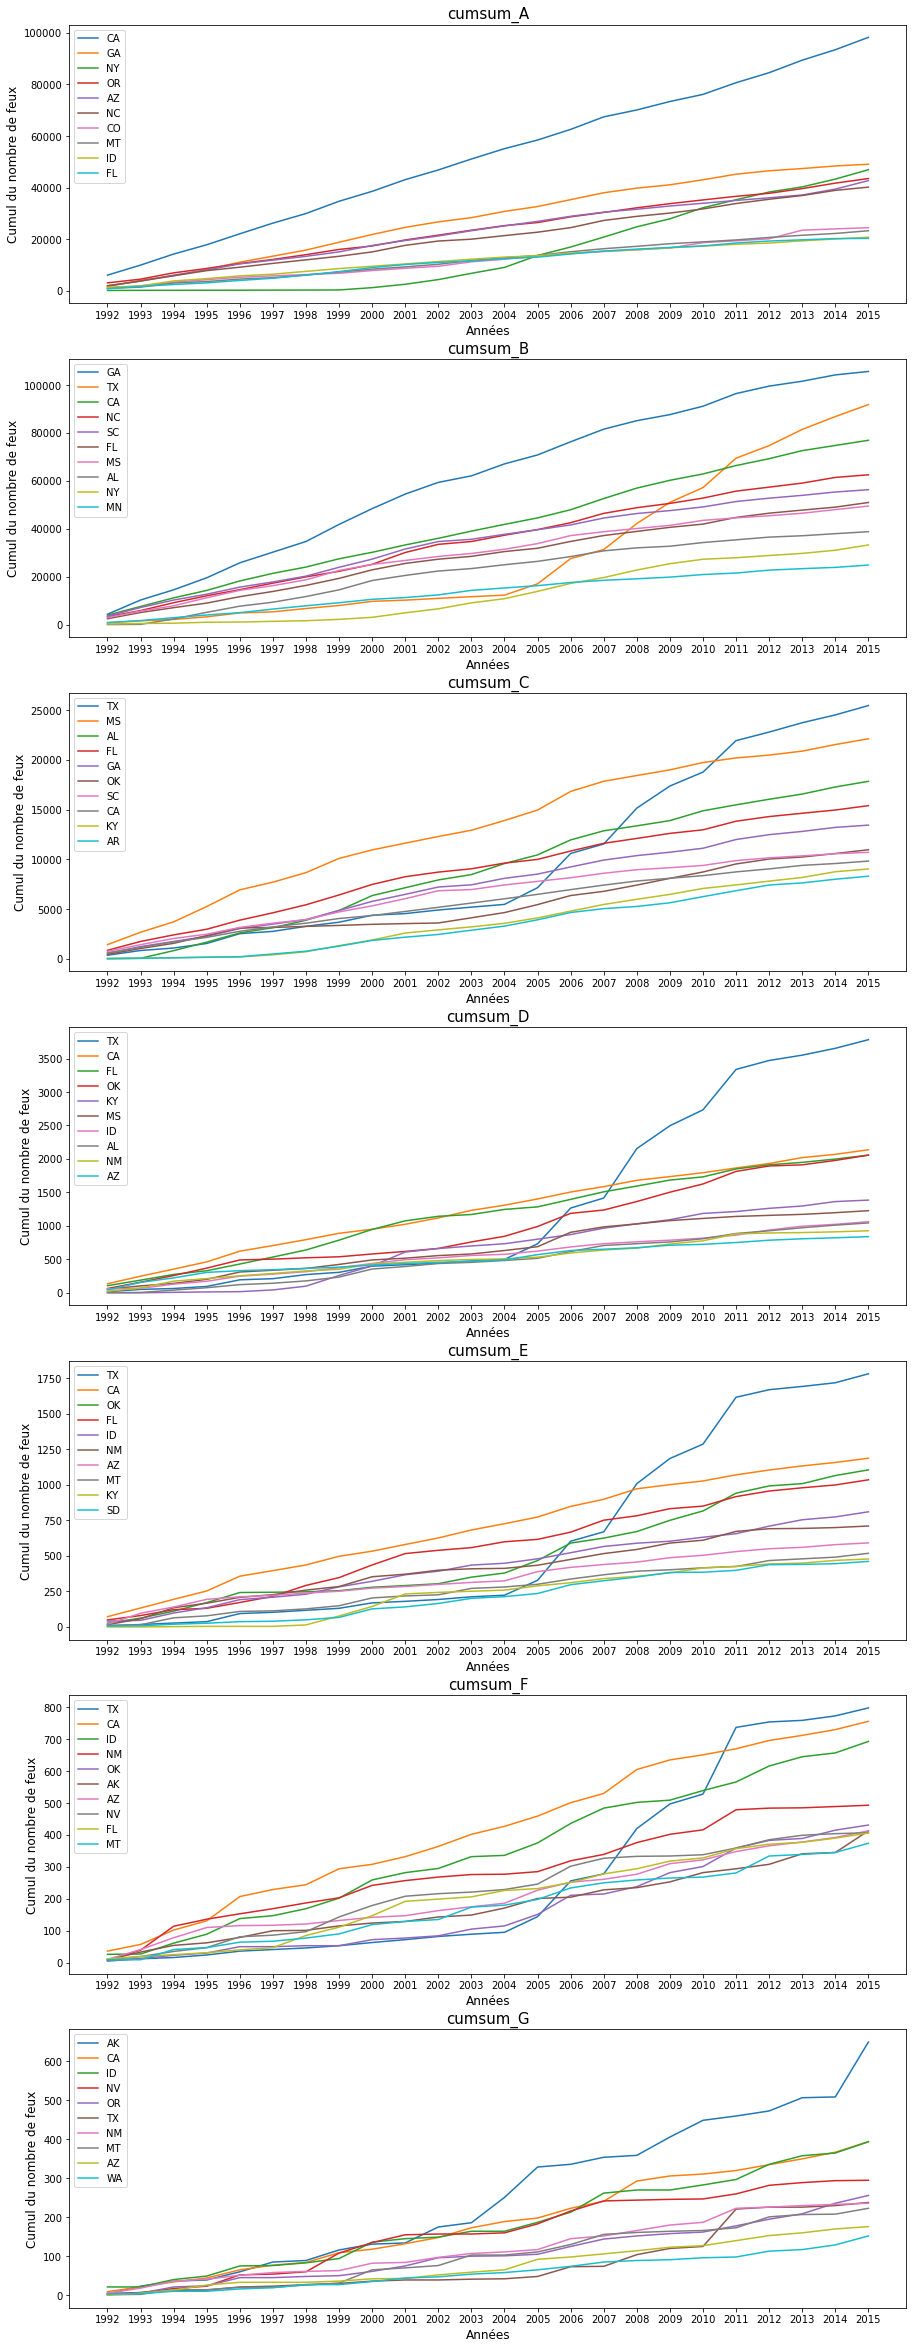

In [31]:
import matplotlib.dates as md
import datetime

fig, axs = plt.subplots(nrows = 7, figsize = (15, 6*7))
for i,j in enumerate(dict_col):
    for k in dict_col[j]:
        sns.lineplot(x = 'FIRE_YEAR', y = j, data = df_adv_count[df_adv_count.STATE == k], label = k, ax = axs[i]).set_title(j, fontsize = 15)
    axs[i].set_xlabel("Années",fontsize=12)
    axs[i].set_ylabel("Cumul du nombre de feux",fontsize=12)
    axs[i].set_xticks(range(1992, 2016, 1))
    axs[i].tick_params(labelsize=10)
plt.legend(loc = 'best');

> **Conclusion n°2 :** La visualisation de l'évolution du nombre de feux, par type de feux, par état permet de relever certains éléments remarquables :
> 1. L'évolution des feux de typa A est sans intérêt
> 2. L'état du Texas (TX) connaît depuis 2004 une augmentation importante du nombre de feux et c'est particulièrement visible pour les feux de type B à F
> 3. L'Alaska connaît une hausse des feux de type G depuis 2003, ce qui est cohérent avec les observations précédentes

##  4- Etude de l'évolution des causes d'incendies

#### Préparation d'un jeu de données dédié au suivi des causes de feux

In [32]:
df_cause = df[['DISCOVERY_DATE', 'STAT_CAUSE_DESCR']]
df_cause = df_cause.merge(pd.get_dummies(df_cause.STAT_CAUSE_DESCR), on = 'OBJECTID')
df_cause.drop('STAT_CAUSE_DESCR', axis = 1, inplace = True)
df_cause

,DISCOVERY_DATE,Arson,Campfire,Children,Debris Burning,Equipment Use,Fireworks,Lightning,Miscellaneous,Missing/Undefined,Powerline,Railroad,Smoking,Structure
OBJECTID,,,,,,,,,,,,,,
1,2005-02-02,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2004-05-12,0,0,0,0,0,0,1,0,0,0,0,0,0
3,2004-05-31,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2004-06-28,0,0,0,0,0,0,1,0,0,0,0,0,0
5,2004-06-28,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880461,2015-09-26,0,0,0,0,0,0,0,0,1,0,0,0,0
1880462,2015-10-05,0,0,0,0,0,0,0,1,0,0,0,0,0
1880463,2015-05-02,0,0,0,0,0,0,0,0,1,0,0,0,0


In [33]:
df_cause.reset_index(inplace = True)
df_cause.drop('OBJECTID', axis =1, inplace = True)
df_cause.set_index('DISCOVERY_DATE', inplace = True)
df_cause

,Arson,Campfire,Children,Debris Burning,Equipment Use,Fireworks,Lightning,Miscellaneous,Missing/Undefined,Powerline,Railroad,Smoking,Structure
DISCOVERY_DATE,,,,,,,,,,,,,
2005-02-02,0,0,0,0,0,0,0,1,0,0,0,0,0
2004-05-12,0,0,0,0,0,0,1,0,0,0,0,0,0
2004-05-31,0,0,0,1,0,0,0,0,0,0,0,0,0
2004-06-28,0,0,0,0,0,0,1,0,0,0,0,0,0
2004-06-28,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-26,0,0,0,0,0,0,0,0,1,0,0,0,0
2015-10-05,0,0,0,0,0,0,0,1,0,0,0,0,0
2015-05-02,0,0,0,0,0,0,0,0,1,0,0,0,0


#### Echantillonage à la semaine avec somme des indicateurs journaliers

In [34]:
df_cause = df_cause.resample('W').sum()
df_cause

,Arson,Campfire,Children,Debris Burning,Equipment Use,Fireworks,Lightning,Miscellaneous,Missing/Undefined,Powerline,Railroad,Smoking,Structure
DISCOVERY_DATE,,,,,,,,,,,,,
1992-01-05,87.0,3.0,18.0,43.0,32.0,1.0,2.0,29.0,81.0,0.0,23.0,11.0,0.0
1992-01-12,155.0,16.0,23.0,187.0,73.0,0.0,1.0,38.0,127.0,0.0,77.0,36.0,0.0
1992-01-19,163.0,9.0,39.0,160.0,73.0,0.0,0.0,103.0,219.0,0.0,54.0,46.0,0.0
1992-01-26,288.0,18.0,62.0,381.0,93.0,0.0,1.0,97.0,226.0,0.0,75.0,53.0,0.0
1992-02-02,199.0,16.0,57.0,325.0,56.0,0.0,0.0,68.0,175.0,1.0,54.0,56.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-06,38.0,12.0,5.0,95.0,23.0,1.0,5.0,124.0,65.0,7.0,0.0,3.0,1.0
2015-12-13,63.0,14.0,3.0,157.0,45.0,0.0,5.0,199.0,67.0,18.0,2.0,18.0,8.0
2015-12-20,37.0,7.0,6.0,71.0,27.0,0.0,0.0,114.0,46.0,8.0,0.0,9.0,1.0


#### Affichage de l'évolution des causes de feux au fil du temps

Liste avec les causes de feux

In [35]:
causes = df_cause.columns
causes

Index(['Arson', 'Campfire', 'Children', 'Debris Burning', 'Equipment Use',
       'Fireworks', 'Lightning', 'Miscellaneous', 'Missing/Undefined',
       'Powerline', 'Railroad', 'Smoking', 'Structure'],
      dtype='object')

Liste de couleurs pour différencier les tracés

In [36]:
list_col = ['lightcoral', 'maroon', 'darkorange', 'goldenrod', 'olive', 'palegreen', 'darkgreen', 'turquoise', 'teal', 'steelblue', 'slategray', 'royalblue', 'indigo', 'purple', 'crimsom', 'black']

Affichage des tracés par point + moyennes mobiles sur 12 semaines

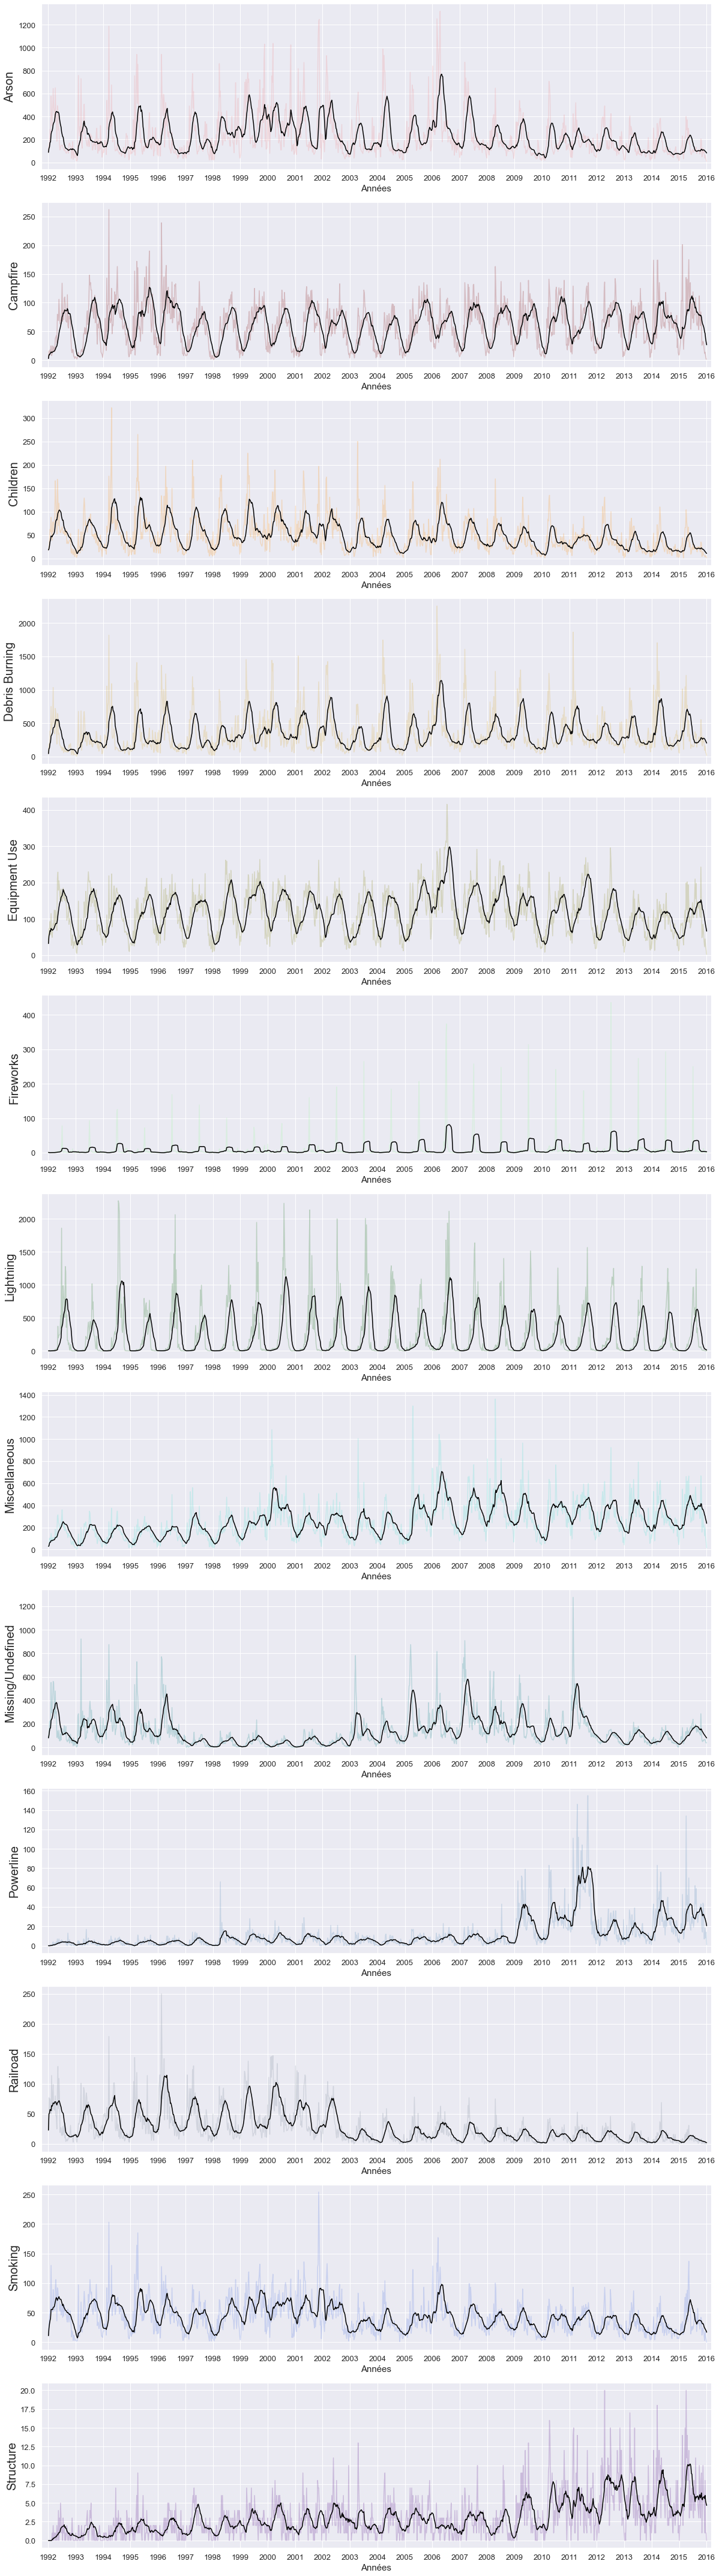

In [37]:
import matplotlib.dates as md
import datetime

sns.set_theme()

fig, axs = plt.subplots(nrows = 13, figsize = (20, 6*13))
for i in range(len(causes)):
    sns.lineplot(x = df_cause.index, y = df_cause.loc[:, causes[i]], ls = '-', alpha = 0.2, color = list_col[i], ax = axs[i])
    sns.lineplot(x = df_cause.index, y = df_cause.loc[:, causes[i]].rolling(12, min_periods=1).mean(), ls = '-', color = 'black', ax = axs[i])
    axs[i].set_xlabel("Années",fontsize=15)
    axs[i].set_ylabel(causes[i],fontsize=20)
    axs[i].xaxis.set_major_locator(md.YearLocator())
    axs[i].xaxis.set_major_formatter(md.DateFormatter('%Y'))
    axs[i].set_xlim([datetime.date(1991, 10, 1), datetime.date(2016, 3, 1)])
    axs[i].tick_params(labelsize=13)

Affichage des tracés par point + tendances

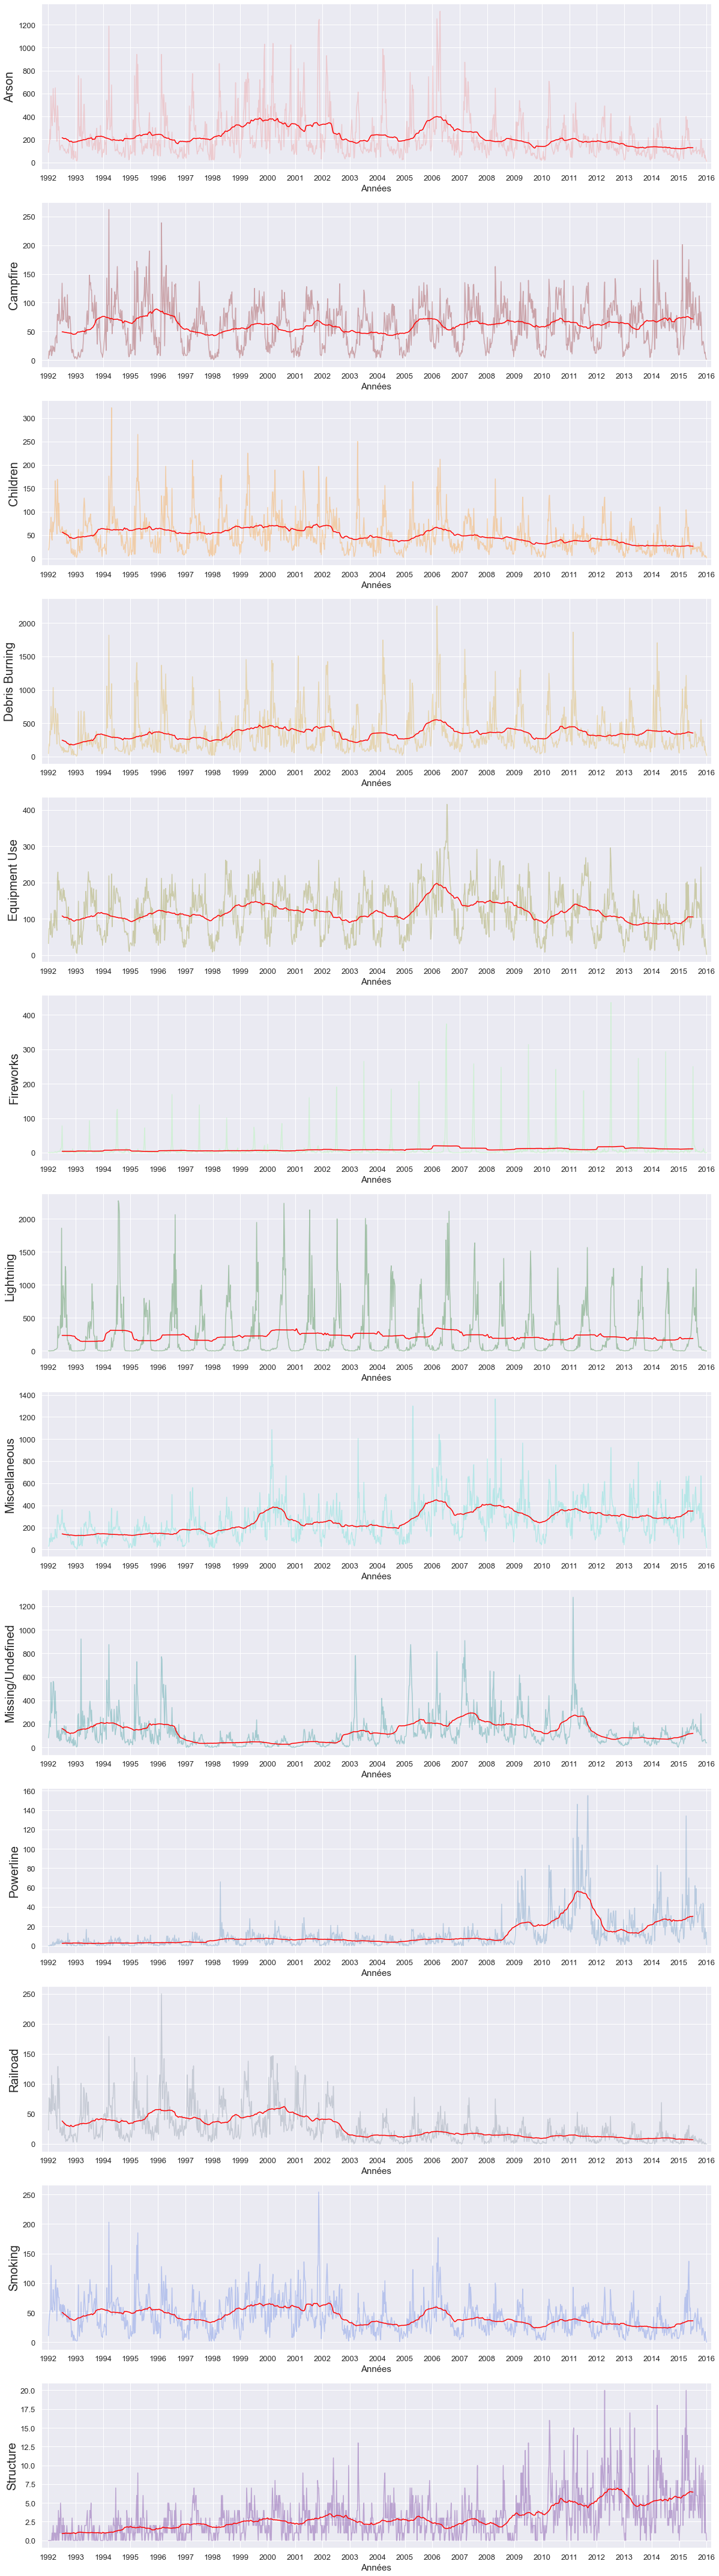

In [38]:
import statsmodels.api as sm
from matplotlib import rcParams
import matplotlib.dates as md
import datetime

fig, axs = plt.subplots(nrows = 13, figsize = (20, 6*13))
for i in range(len(causes)):
    sns.lineplot(x = df_cause.index, y = df_cause.loc[:, causes[i]], ls = '-', alpha = 0.3, color = list_col[i], ax = axs[i])
    decomposition = sm.tsa.seasonal_decompose(df_cause.loc[:, causes[i]], model = 'additive')
    sns.lineplot(x = decomposition.trend.index, y = decomposition.trend, ls = '-', color = 'red', ax = axs[i])
    axs[i].set_xlabel("Années",fontsize=15)
    axs[i].set_ylabel(causes[i],fontsize=20)
    axs[i].xaxis.set_major_locator(md.YearLocator())
    axs[i].xaxis.set_major_formatter(md.DateFormatter('%Y'))
    axs[i].set_xlim([datetime.date(1991, 10, 1), datetime.date(2016, 3, 1)])
    axs[i].tick_params(labelsize=13)

> **Conclusion n°3 :** La visualisation de l'évolution des causes d'incendies déclarées montre :
> 1. Qu'elles sont toutes sujettes à une saisonnalité liée a priori aux conditions climatiques et/ou aux activités liées aux saisons
> 2. Que certaines causes vont l'objet d'évolutions remarquables :
>    1. Les feux liés aux lignes électriques ont connu une forte hausse entre 2008 et 2011, et ils repartent sur une tendance à la hausse
>    2. Les feux liés aux structures sont en hausse régulière depuis 2008
>    3. A contrario les feux liés aux activités ferroviaires ont baissé significativement à partir de 2003